**PARTE 1 - SISTEMA de RECOM - OPENSEARCH - API**

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


• Importar bases de datos con las cuales se va a trabajar.

In [115]:
# Base de datos
import pandas as pd

movies_df = pd.read_csv('peliculas.csv')
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])

ratings_df = pd.read_csv('scores.csv')
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])


In [116]:
# Merge de bases para agregar género
movies_df_join = movies_df[["id", 'Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']]

ratings = ratings_df.merge(movies_df_join, how='left', left_on="movie_id", right_on="id", suffixes=("", ""))
ratings = ratings.drop(columns=['id'])

ratings_df = ratings
ratings_df.head()

,Unnamed: 0,user_id,movie_id,rating,Date,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,196,242,3,1997-12-04 15:55:49,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,186,302,3,1998-04-04 19:22:22,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,2,22,377,1,1997-11-07 07:18:36,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,244,51,2,1997-11-27 05:02:03,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,4,166,346,1,1998-02-02 05:33:16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


•	Crear un sistema de recomendación Model Based utilizando una red neuronal con matriz de embeddings de usuarios y otra matriz de embeddings de películas. No es necesario que la dimensión de los embeddings de películas y usuarios sean iguales.

In [ ]:
# Establezco trakeo de corridas en MLFLOW para seleccionar modelo
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment('Integrador2')

In [117]:
# Conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(ratings_df, test_size=0.2, random_state=98)
len(train_df), len(val_df)

(80000, 20000)

In [118]:
# Parámetros
n_latent_factors_user = 10
n_latent_factors_movie = 15
learning_rate = 0.002183
batch_size = 319
epochs = 12

#Hiperparámetros base: [10, 15, 0.0005, 350, 15]
#Mejores hiperparámetros encontrados: [41, 13, 0.0021830968390524623, 319, 12]

In [119]:
# Variables
n_users = int(ratings_df.user_id.nunique())
n_movies = int(ratings_df.movie_id.nunique())
n_users_train = int(train_df.user_id.nunique())
n_movies_train = int(train_df.movie_id.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

max_rating = train_df['rating'].max()
min_rating = train_df['rating'].min()
av_rating = train_df['rating'].mean()
print(max_rating, min_rating, av_rating)

genre = ['Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

943 1682 943 1640
5 1 3.5304875


In [120]:
# Configuración del modelo
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Lambda, Add, Dropout
from keras.regularizers import l2
from keras import Model
from keras.optimizers import Adam

#genre_input = Input(shape=[len(genre)],name='genre')

movie_input = Input(shape=[1], name='Item')
movie_embedding = Embedding(n_movies + 1, 
                            n_latent_factors_movie, 
                            name='Movie-Embedding', 
                            embeddings_regularizer = l2(0.001) #regularizador
                            )(
                            movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_embeddings = Embedding(n_users + 1, 
                            n_latent_factors_user, 
                            name='User-Embedding', 
                            embeddings_regularizer = l2(0.001) #regularizador
                            )(
                            user_input)
user_vec = Flatten(name='FlattenUsers')(user_embeddings)

concat = Concatenate(name='Concat')([movie_vec, user_vec]) #genre_input

dense1 = Dense(128, name='FullyConnected-1', activation='relu')(concat)
#dropout = Dropout(0.4)(dense1)
dense2 = Dense(64, name='FullyConnected-2', activation='relu')(dense1) #dropout
output = Dense(1)(dense2)
#output = Dense(1, name='End', activation='sigmoid')(dense2)
#output = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(output)

model = Model([user_input, movie_input],[output]) #genre_input
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 15)                25245     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 10)                9440      ['User[0][0]']         

In [121]:
# Configuración de la función de pérdidas y métrica a utilizar
import keras.backend as K 

#def root_mean_squared_error(y_true, y_pred):
#    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])

In [122]:
#Búsqueda de hiperparámetros OPT BAYESINA
from skopt import gp_minimize
from skopt.space import Integer, Real
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Espacio de búsqueda
param_space = [
    Integer(5, 50, name='n_latent_factors_user'),   
    Integer(5, 50, name='n_latent_factors_movie'),  
    Real(1e-5, 1e-2, prior='log-uniform', name='learning_rate'),  
    Integer(50, 500, name='batch_size'),            
    Integer(5, 20, name='epochs')                   
]

# Función objetivo a minimizar
def objective(params):
    n_latent_factors_user, n_latent_factors_movie, learning_rate, batch_size, epochs = params
    
    user_input = Input(shape=[1], name='User')
    movie_input = Input(shape=[1], name='Item')

    movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer=l2(0.001))(movie_input)
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
    user_embeddings = Embedding(n_users + 1, n_latent_factors_user, name='User-Embedding', embeddings_regularizer=l2(0.001))(user_input)
    user_vec = Flatten(name='FlattenUsers')(user_embeddings)

    concat = Concatenate(name='Concat')([movie_vec, user_vec])
    
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)
    
    model = Model([user_input, movie_input], output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    
    # Dividir datos para entrenamiento y validación
    train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    history = model.fit(
        [train_data['user_id'].values, train_data['movie_id'].values], train_data['rating'].values,
        validation_data=([val_data['user_id'].values, val_data['movie_id'].values], val_data['rating'].values),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )
    
    # Evaluar la pérdida de validación
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimización bayesiana
opt_result = gp_minimize(
    func=objective,        
    dimensions=param_space,  
    n_calls=20,             
    random_state=42,        
    verbose=True
)

# Mejores hiperparámetros
print("Mejores hiperparámetros encontrados:", opt_result.x)


Iteration No: 1 started. Evaluating function at random point.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.1645
Function value obtained: 0.9275
Current minimum: 0.9275
Iteration No: 2 started. Evaluating function at random point.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.2250
Function value obtained: 0.9311
Current minimum: 0.9275
Iteration No: 3 started. Evaluating function at random point.
Epoch 9: early stopping


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.8986
Function value obtained: 1.0364
Current minimum: 0.9275
Iteration No: 4 started. Evaluating function at random point.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.6069
Function value obtained: 0.9857
Current minimum: 0.9275
Iteration No: 5 started. Evaluating function at random point.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7411
Function value obtained: 1.0094
Current minimum: 0.9275
Iteration No: 6 started. Evaluating function at random point.
Epoch 11: early stopping


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.2097
Function value obtained: 1.0089
Current minimum: 0.9275
Iteration No: 7 started. Evaluating function at random point.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.8928
Function value obtained: 7.1492
Current minimum: 0.9275
Iteration No: 8 started. Evaluating function at random point.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.0156
Function value obtained: 0.9302
Current minimum: 0.9275
Iteration No: 9 started. Evaluating function at random point.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 1.9468
Function value obtained: 1.0207
Current minimum: 0.9275
Iteration No: 10 started. Evaluating function at random point.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.3430
Function value obtained: 1.1466
Current minimum: 0.9275
Iteration No: 11 started. Searching for the next optimal point.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 7.7722
Function value obtained: 1.0469
Current minimum: 0.9275
Iteration No: 12 started. Searching for the next optimal point.
Epoch 9: early stopping


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 2.6642
Function value obtained: 1.0292
Current minimum: 0.9275
Iteration No: 13 started. Searching for the next optimal point.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.7432
Function value obtained: 1.0789
Current minimum: 0.9275
Iteration No: 14 started. Searching for the next optimal point.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 6.5569
Function value obtained: 1.0824
Current minimum: 0.9275
Iteration No: 15 started. Searching for the next optimal point.
Epoch 4: early stopping


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.1297
Function value obtained: 0.9963
Current minimum: 0.9275
Iteration No: 16 started. Searching for the next optimal point.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 3.7443
Function value obtained: 1.2887
Current minimum: 0.9275
Iteration No: 17 started. Searching for the next optimal point.
Epoch 13: early stopping


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.8768
Function value obtained: 1.0113
Current minimum: 0.9275
Iteration No: 18 started. Searching for the next optimal point.
Epoch 7: early stopping


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.7970
Function value obtained: 0.9969
Current minimum: 0.9275
Iteration No: 19 started. Searching for the next optimal point.
Epoch 6: early stopping


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.5003
Function value obtained: 1.0238
Current minimum: 0.9275
Iteration No: 20 started. Searching for the next optimal point.
Epoch 11: early stopping
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.2819
Function value obtained: 1.0138
Current minimum: 0.9275
Mejores hiperparámetros encontrados: [41, 13, 0.0021830968390524623, 319, 12]


In [123]:
# Entrenamiento
import keras.callbacks

entrenamiento = model.fit([train_df.user_id, train_df.movie_id], #train_df[genre]
                    train_df.rating, 
                    validation_data=([val_df.user_id, val_df.movie_id], #val_df[genre]
                                     val_df.rating), 
                    batch_size=batch_size,
                    epochs=epochs, 
                    callbacks =[keras.callbacks.TensorBoard(update_freq='batch')],
                    verbose=1)

Epoch 1/12
251/251 [==============================] - 0s 1ms/step - loss: 1.7800 - mean_squared_error: 1.7481 - val_loss: 0.9518 - val_mean_squared_error: 0.9153
Epoch 2/12
251/251 [==============================] - 0s 1ms/step - loss: 0.9339 - mean_squared_error: 0.8970 - val_loss: 0.9410 - val_mean_squared_error: 0.9045
Epoch 3/12
251/251 [==============================] - 0s 1ms/step - loss: 0.9230 - mean_squared_error: 0.8864 - val_loss: 0.9340 - val_mean_squared_error: 0.8975
Epoch 4/12
251/251 [==============================] - 0s 1ms/step - loss: 0.9113 - mean_squared_error: 0.8725 - val_loss: 0.9206 - val_mean_squared_error: 0.8795
Epoch 5/12
251/251 [==============================] - 0s 1ms/step - loss: 0.8967 - mean_squared_error: 0.8537 - val_loss: 0.9157 - val_mean_squared_error: 0.8721
Epoch 6/12
251/251 [==============================] - 0s 1ms/step - loss: 0.8861 - mean_squared_error: 0.8407 - val_loss: 0.9121 - val_mean_squared_error: 0.8665
Epoch 7/12
251/251 [========

In [124]:
# Resultados test
val_loss, val_metric = model.evaluate([val_df.user_id, val_df.movie_id], val_df.rating) #val_df[genre]
val_loss, val_metric

625/625 [==============================] - 0s 289us/step - loss: 0.9051 - mean_squared_error: 0.8450


(0.9050663113594055, 0.8450133800506592)

In [125]:
# Resultados train
loss, metric = model.evaluate([train_df.user_id, train_df.movie_id], train_df.rating) #train_df[genre]
loss, metric

2500/2500 [==============================] - 1s 280us/step - loss: 0.7667 - mean_squared_error: 0.7066


(0.7666733860969543, 0.7066198587417603)

Text(0.5, 0, 'Epochs')

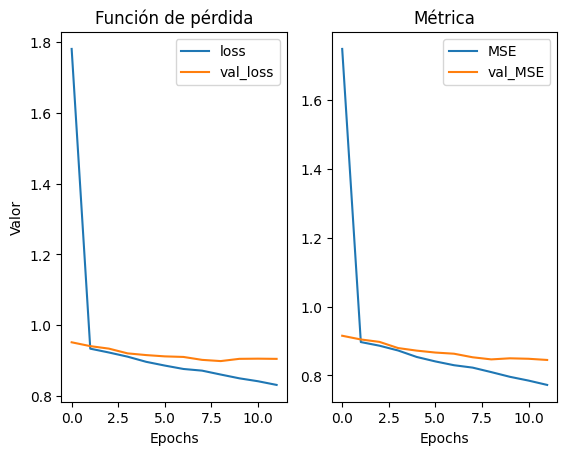

In [126]:
# Gráficas
from matplotlib import pyplot as plt

plt.subplot(1, 2, 1)
plt.title('Función de pérdida')
plt.legend()
plt.plot(entrenamiento.history['loss'], label='loss')
plt.plot(entrenamiento.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Valor")

plt.subplot(1, 2, 2)
plt.title('Métrica')
plt.plot(entrenamiento.history['mean_squared_error'], label='MSE')
plt.plot(entrenamiento.history['val_mean_squared_error'], label='val_MSE')
plt.legend()
plt.xlabel("Epochs")


In [75]:
# Trakeo de corridas en MLFLOW para seleccionar modelo
mlflow.start_run(run_name="sinL2emb") #cambiar nombre según modelo a prueba
mlflow.log_params({
    'n_latent_factors_u': n_latent_factors_user,
    'n_latent_factors_m': n_latent_factors_movie,
    'learning_rate': learning_rate,
    'batch': batch_size,
    'epochs': epochs
})
mlflow.log_metrics({
    'loss': loss, 'metric': metric,
    'val_loss': val_loss, 'val_metric': val_metric,
})
mlflow.end_run()

In [66]:
# Muestra al azar de val_df para prueba
val_df.sample(n=2)

,Unnamed: 0,user_id,movie_id,rating,Date,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
20622,20622,252,14,4,1998-04-01 18:54:36,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
57480,57480,416,157,4,1998-02-01 07:15:16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [127]:
# Prueba
user_id = 252
movie_id = 14
prediction = model.predict([pd.Series([user_id]), pd.Series([movie_id])])
print(f'Predicted rating for user {user_id} and movie {movie_id}: {prediction}')

user_id = 416
movie_id = 157
prediction = model.predict([pd.Series([user_id]), pd.Series([movie_id])])
print(f'Predicted rating for user {user_id} and movie {movie_id}: {prediction}')

1/1 [==============================] - 0s 22ms/step
Predicted rating for user 252 and movie 14: [[4.48506]]
1/1 [==============================] - 0s 9ms/step
Predicted rating for user 416 and movie 157: [[4.0892563]]


•	Almacenar los vectores de películas y personas en una base de datos vectorial (OpenSearch).

In [128]:
# Embeddings
movie_embeddings_weights = model.layers[2].get_weights()[0]
user_embeddings_weights = model.layers[3].get_weights()[0]
movie_embeddings_weights.shape, user_embeddings_weights.shape, n_movies, n_users

((1683, 15), (944, 10), 1682, 943)

In [129]:
# Conversión de los embeddings a "json"
import json

# Convertir los embeddings a listas
user_embeddings_list = user_embeddings_weights.tolist()
movie_embeddings_list = movie_embeddings_weights.tolist()

# Crear un diccionario para los datos
data = {
    'users': user_embeddings_list,
    'movies': movie_embeddings_list
}

# Convertir a JSON
json_data = json.dumps(data)

In [130]:
# Conexión a OpenSearh
from opensearchpy import OpenSearch, RequestsHttpConnection

client = OpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'gamartiarena/itba123'),  # Ajustar credenciales
    use_ssl=False,
    verify_certs=False,
    connection_class=RequestsHttpConnection
)

In [131]:
# Indexación

# Crear índices
client.indices.create(index='user_embeddings', ignore=400)
client.indices.create(index='movie_embeddings', ignore=400)

# Indexar los embeddings de usuarios
for user_id, vector in enumerate(user_embeddings_list):
    client.index(
        index='user_embeddings',
        id=user_id,
        body={'embedding': vector}
    )

# Indexar los embeddings de películas
for movie_id, vector in enumerate(movie_embeddings_list):
    client.index(
        index='movie_embeddings',
        id=movie_id,
        body={'embedding': vector}
    )

In [45]:
#Acceso a los embeddings en OpenSearch
#curl -X GET "http://localhost:9200/user_embeddings/_search?pretty=true&q=*:*"
#curl -X GET "http://localhost:9200/movie_embeddings/_search?pretty=true&q=*:*"

In [132]:
# Guardado de embeddings de usuarios como archivo
import numpy as np
np.save("user_embeddings_weights.npy", user_embeddings_weights)
np.save("movie_embeddings_weights.npy", movie_embeddings_weights)

* Implementar una API para que se puedan realizar las siguientes consultas:
1) Dado un usuario (ID y un número K), que la API devuelva las K recomendaciones de películas para ese usuario (Recomendación Model Based)
2) Dado una película (ID y un número K) que la API devuelva las K películas más similares a esa película. (More like this de Netflix) 
3) Para película recomendada en los puntos anteriores, devolver como mínimo nombre, año, url, géneros y lugar en el ranking de la recomendación de la película. Obtener los datos de la película de la DB relacional.


In [133]:
#Salvado y verificación la existencia del modelo
import tensorflow as tf
import os
print(os.getcwd())

# Salvar el modelo
model.save('modelo_recomendacion.h5')

# Verificar su existencia
model = tf.keras.models.load_model('modelo_recomendacion.h5')

/Users/gamartiarena/Documents/Python/integrador2


/opt/anaconda3/envs/integrador2/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [114]:
#USAR ESTE COMANDO PARA CAMBIAR EL NOMBRE DE LA COLUMNA CHILDREN EN PELICULAS
## ALTER TABLE peliculas
## RENAME COLUMN "Children's" TO children;

# API
import tensorflow as tf
import os
from flask import Flask, jsonify
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import psycopg2

# Verificar directorio actual
print(os.getcwd())

# Cargar el modelo
model = tf.keras.models.load_model('modelo_recomendacion.h5')

# Número de usuarios y películas
num_users = user_embeddings_weights.shape[0]
num_movies = movie_embeddings_weights.shape[0]

# Crear la aplicación Flask
app = Flask(__name__)

# Conectar a la base de datos PostgreSQL
def connect_db():
    conn = psycopg2.connect(
        host="localhost", 
        port=5432,
        database="gamartiarena",
        user="gamartiarena",
        password="itba123"
    )
    return conn

# Configurar consultas
@app.route('/')
def home():
    return "¡Bienvenido a la página principal!"

# REC1: Dado un usuario (ID y un número K), API devuelva las K recomendaciones de películas para ID
#http://127.0.0.1:5018//recommend_movies/45/3
@app.route('/recommend_movies/<int:user_id>/<int:k>')
def recommend_movies(user_id, k):
    # Obtener predicciones de usuario indicador para todas las películas
    all_movie_ids = np.arange(num_movies)
    predictions = model.predict([np.full(num_movies, user_id), all_movie_ids]).flatten()

    # Ordenar las películas por predicción (de mayor a menor)
    top_movie_indices = np.argsort(predictions)[::-1][:k]
    top_movie_ids = all_movie_ids[top_movie_indices]

    # Conectarse a la base de datos y obtener detalles de las películas
    conn = connect_db()
    cur = conn.cursor()

    # Consulta para obtener información de las películas recomendadas
    movie_details = []
    for movie_id in top_movie_ids:
        cur.execute("""
            SELECT "Name", "Release Date", "IMDB URL", 
            CASE 
                WHEN "unknown" = 1 THEN 'Unknown'
                ELSE CONCAT_WS(',', 
                    CASE WHEN "Action" = 1 THEN 'Action' ELSE NULL END,
                    CASE WHEN "Adventure" = 1 THEN 'Adventure' ELSE NULL END,
                    CASE WHEN "Animation" = 1 THEN 'Animation' ELSE NULL END,
                    CASE WHEN "Children's" = 1 THEN 'children' ELSE NULL END,
                    CASE WHEN "Comedy" = 1 THEN 'Comedy' ELSE NULL END,
                    CASE WHEN "Crime" = 1 THEN 'Crime' ELSE NULL END,
                    CASE WHEN "Documentary" = 1 THEN 'Documentary' ELSE NULL END,
                    CASE WHEN "Drama" = 1 THEN 'Drama' ELSE NULL END,
                    CASE WHEN "Fantasy" = 1 THEN 'Fantasy' ELSE NULL END,
                    CASE WHEN "Film-Noir" = 1 THEN 'Film-Noir' ELSE NULL END,
                    CASE WHEN "Horror" = 1 THEN 'Horror' ELSE NULL END,
                    CASE WHEN "Musical" = 1 THEN 'Musical' ELSE NULL END,
                    CASE WHEN "Mystery" = 1 THEN 'Mystery' ELSE NULL END,
                    CASE WHEN "Romance" = 1 THEN 'Romance' ELSE NULL END,
                    CASE WHEN "Sci-Fi" = 1 THEN 'Sci-Fi' ELSE NULL END,
                    CASE WHEN "Thriller" = 1 THEN 'Thriller' ELSE NULL END,
                    CASE WHEN "War" = 1 THEN 'War' ELSE NULL END,
                    CASE WHEN "Western" = 1 THEN 'Western' ELSE NULL END
                )
            END AS generos
            FROM peliculas 
            WHERE id = %s
        """, (int(movie_id),))
        result = cur.fetchone()
        
        if result:
            movie_details.append({
                'id': movie_id,
                'name': result[0],
                'release_date': result[1],
                'imdb_url': result[2],
                'generos': result[3],
                'ranking': int(np.where(top_movie_ids == movie_id)[0][0]) + 1  # Posición en el ranking
            })

    conn.close()

    def convert_to_standard_types(data):
      if isinstance(data, np.int32):
        return int(data)
      elif isinstance(data, np.int64):
        return int(data)
      elif isinstance(data, list):
        return [convert_to_standard_types(item) for item in data]
      elif isinstance(data, dict):
        return {key: convert_to_standard_types(value) for key, value in data.items()}
      else:
        return data

    movie_details = convert_to_standard_types(movie_details)
    return jsonify({'recommended_movies': movie_details})

  
# REC2: Dada una película (ID y un número K), API devuelva lasnK películas más similares a esa película
#http://127.0.0.1:5018//similar_movies/17/4
@app.route('/similar_movies/<int:movie_id>/<int:k>')
def similar_movies(movie_id, k):
    # Calcular la similitud del coseno entre la película dada y todas las demás
    similarity_scores = cosine_similarity([movie_embeddings_weights[movie_id]], movie_embeddings_weights)

    # Obtener los índices de las películas más similares (excluyendo la película dada)
    top_movie_indices = np.argsort(similarity_scores[0])[::-1][1:k+1]
    top_movie_ids = np.array(range(num_movies))[top_movie_indices]

    # Conectarse a la base de datos y obtener detalles de las películas similares
    conn = connect_db()
    cur = conn.cursor()

    # Consulta para obtener información de las películas similares
    movie_details = []
    for movie_id in top_movie_ids:
        cur.execute("""
            SELECT "Name", "Release Date", "IMDB URL", 
            CASE 
                WHEN "unknown" = 1 THEN 'Unknown'
                ELSE CONCAT_WS(',', 
                    CASE WHEN "Action" = 1 THEN 'Action' ELSE NULL END,
                    CASE WHEN "Adventure" = 1 THEN 'Adventure' ELSE NULL END,
                    CASE WHEN "Animation" = 1 THEN 'Animation' ELSE NULL END,
                    CASE WHEN "Children's" = 1 THEN 'children' ELSE NULL END,
                    CASE WHEN "Comedy" = 1 THEN 'Comedy' ELSE NULL END,
                    CASE WHEN "Crime" = 1 THEN 'Crime' ELSE NULL END,
                    CASE WHEN "Documentary" = 1 THEN 'Documentary' ELSE NULL END,
                    CASE WHEN "Drama" = 1 THEN 'Drama' ELSE NULL END,
                    CASE WHEN "Fantasy" = 1 THEN 'Fantasy' ELSE NULL END,
                    CASE WHEN "Film-Noir" = 1 THEN 'Film-Noir' ELSE NULL END,
                    CASE WHEN "Horror" = 1 THEN 'Horror' ELSE NULL END,
                    CASE WHEN "Musical" = 1 THEN 'Musical' ELSE NULL END,
                    CASE WHEN "Mystery" = 1 THEN 'Mystery' ELSE NULL END,
                    CASE WHEN "Romance" = 1 THEN 'Romance' ELSE NULL END,
                    CASE WHEN "Sci-Fi" = 1 THEN 'Sci-Fi' ELSE NULL END,
                    CASE WHEN "Thriller" = 1 THEN 'Thriller' ELSE NULL END,
                    CASE WHEN "War" = 1 THEN 'War' ELSE NULL END,
                    CASE WHEN "Western" = 1 THEN 'Western' ELSE NULL END
                )
            END AS generos
            FROM peliculas 
            WHERE id = %s
        """, (int(movie_id),))
        result = cur.fetchone()
        
        if result:
            movie_details.append({
                'id': movie_id,
                'name': result[0],
                'release_date': result[1],
                'imdb_url': result[2],
                'generos': result[3],
                'similarity_score': float(similarity_scores[0][movie_id])  # Similaridad de coseno
            })

    conn.close()

    def convert_to_standard_types(data):
        if isinstance(data, np.int32):
            return int(data)
        elif isinstance(data, np.int64):
            return int(data)
        elif isinstance(data, list):
            return [convert_to_standard_types(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_to_standard_types(value) for key, value in data.items()}
        else:
            return data

    movie_details = convert_to_standard_types(movie_details)
    return jsonify({'similar_movies': movie_details})


# Iniciar la aplicación Flask
if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5018))
    app.run(host='0.0.0.0', port=port, debug=True, use_reloader=False)

/Users/gamartiarena/Documents/Python/integrador2
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5018
 * Running on http://192.168.68.70:5018
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [08/Nov/2024 20:24:22] "GET /similar_movies/17/4 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Nov/2024 20:24:30] "GET /similar_movies/1/4 HTTP/1.1" 200 -
